In [26]:
# compute
import numpy as np

# interpolation and triangulation
import scipy.interpolate
import scipy.spatial
import matplotlib.tri

# colormapping
import matplotlib.cm
import matplotlib.colors

# interact
from ipywidgets import interact

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
xyz = np.loadtxt('6400x4800, zonder zandmotor.xyz')
# xyz = np.loadtxt('6650x5000, zonder zandmotor.xyz')
# xyz = np.loadtxt('6400x4800, met zandmotor.xyz')

In [28]:
# we need a few extra points around the edge so we know that we have a square
# define an interpolation function
L = scipy.interpolate.NearestNDInterpolator(xyz[:,:2], xyz[:,2])
xmin = xyz[:,0].min()
xmax = xyz[:,0].max()
ymin = xyz[:,1].min()
ymax = xyz[:,1].max()

Y, X = np.mgrid[(ymin-20):(ymax+20):100, (xmin-20):(xmax+20):2j]
xy_extra = np.c_[X.ravel(), Y.ravel()]
# create a xyz
xyz_extra = np.hstack((xy_extra, L(xy_extra)[:,np.newaxis]))
# append to xyz
xyz = np.vstack((xyz, xyz_extra))

Y, X = np.mgrid[(ymin-20):(ymax+20):2j, (xmin-20):(xmax+20):100]
xy_extra = np.c_[X.ravel(), Y.ravel()]
# create xyz
xyz_extra = np.hstack((xy_extra, L(xy_extra)[:,np.newaxis]))
# append to xyz
xyz = np.vstack((xyz, xyz_extra))

In [29]:
# convert from world to engineering coordinates (our local sandbox)
# also cleanup and rescale vertical > 0 different from vertical < 0
def x2bak(x):
    # from 0,6400m to 1.28m
    result = (x/6400.)*1.28
    return result
def y2bak(y):
    # from 0,4800m to 1m
    result = (y/4800.)*.96
    return result
def z2bak(z):
    # chop
    z[z < -12] = -12.
    z[z > 0] *= .5
    z[z > 12] = 12.
    
    # raise to 0
    z -= -12
    
    # from 0,24m to 0.20m
    result = (z/24.)*0.2
    return result

xyz_scaledd = np.c_[
    x2bak(xyz[:,0].copy()),
    y2bak(xyz[:,1].copy()),
    z2bak(xyz[:,2].copy())
]

# remove all the points lower than 1 mm
# xyz_scaled = xyz_scaled[xyz_scaled[:,2]>.001]

In [30]:
# remove all the points lower than 1 mm

bigger_than_1mm = xyz_scaledd[:,2]>.01
xyz_scaled = np.zeros((np.sum(bigger_than_1mm), 3))

xyz_scaled[:,0] = xyz_scaledd[:,0][bigger_than_1mm]
xyz_scaled[:,1] = xyz_scaledd[:,1][bigger_than_1mm]
xyz_scaled[:,2] = xyz_scaledd[:,2][bigger_than_1mm]

In [31]:
# define a triangular mesh
tri = matplotlib.tri.Triangulation(xyz_scaled[:,0], xyz_scaled[:,1])

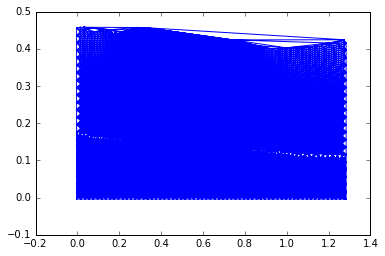

In [32]:
# this should look somewhat regular, it's the basis for the mesh
_ = plt.triplot(tri)

In [33]:
# rescale z to 0,1 for computing colors
N = matplotlib.colors.Normalize(xyz[:,2].min(), xyz[:,2].max())
N = matplotlib.colors.Normalize(0, .2)

In [34]:
# see https://github.com/dranjan/python-plyfile
# compute vertex array (bit of hack with the tulpes)
vertex = np.array([
        tuple(row) 
        for row
        in xyz_scaled.tolist()
    ], dtype=[
        ('x', 'f4'),
        ('y', 'f4'),
        ('z', 'f4')
    ])

# create a list of tuples followed by red,green,blue
facelist = []
for triangle in tri.triangles:
    z_triangle = xyz_scaled[triangle[0], 2]
    r, g, b, a = matplotlib.cm.gist_earth(N(z_triangle), bytes=True)
    facelist.append((triangle, r, g, b))
    
face = np.array(facelist,
                dtype=[
        ('vertex_indices', 'i4', (3,)),
        ('red', 'u1'), ('green', 'u1'),
        ('blue', 'u1')
    ])

In [35]:
import plyfile

ply = plyfile.PlyData([
        plyfile.PlyElement.describe(
                vertex, 'vertex',
                comments=['tetrahedron vertices']
        ),
        plyfile.PlyElement.describe(face, 'face')
    ],
    text=True, 
    byte_order='=',
    comments=['single tetrahedron with colored faces']
)
ply.write('filename.ply')

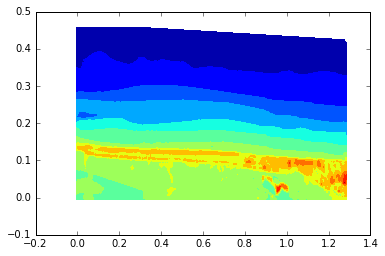

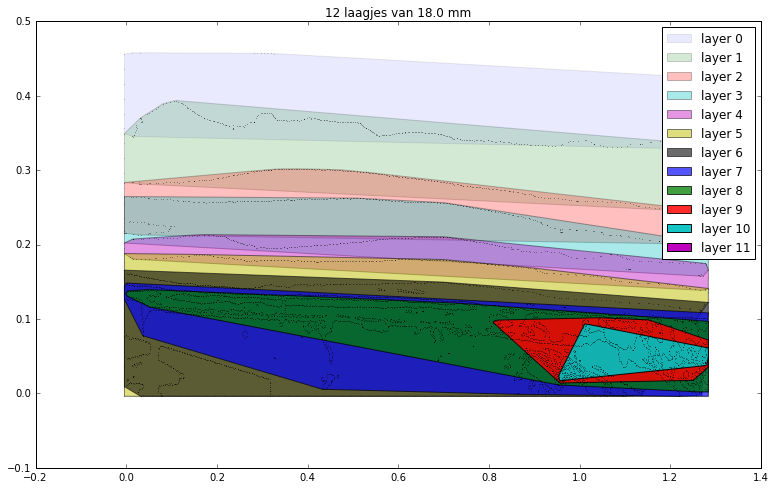

In [36]:
t_wood = .018
V = np.arange(0, 0.2+t_wood, t_wood)
# print 'layer boundaries:', V

contours = plt.tricontourf(tri, xyz_scaled[:,2], V)

plt.subplots(figsize=(13, 8))
for i, segment in enumerate(contours.allsegs):
    contour = segment[0]
    hull = scipy.spatial.ConvexHull(contour)
    hull_points = hull.points[hull.vertices]
    plt.plot(contour[:,0], contour[:,1], 'k.', alpha=0.2, markersize=1)
    plt.fill(hull_points[:,0], hull_points[:,1], alpha=(i+1.) / len(contours.allsegs), label='layer '+str(i))
#     plt.plot(hull_points[:,0], hull_points[:,1], label='layer '+str(i))

plt.legend()
plt.title(str(len(V)-1) + ' laagjes van ' + str(t_wood*1000) + ' mm');

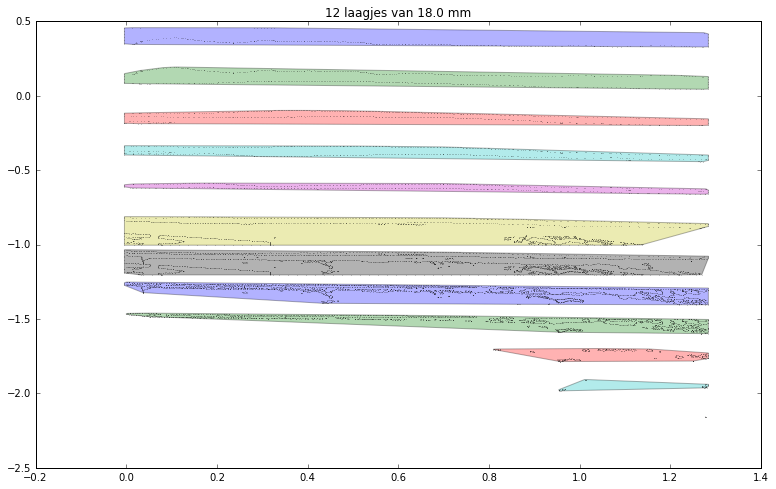

In [37]:
plt.figure(figsize=(13, 8))
for i, segment in enumerate(contours.allsegs):
    contour = segment[0]
    plt.plot(contour[:,0], contour[:,1] + i * -.2, 'k.', alpha=0.2, markersize=1)
    hull = scipy.spatial.ConvexHull(contour)
    hull_points = hull.points[hull.vertices]
    plt.fill(hull_points[:,0], hull_points[:,1] + i * -.2, alpha=0.3)
    
plt.title(str(len(V)-1) + ' laagjes van ' + str(t_wood*1000) + ' mm')

In [38]:
# Determine maximum y value of each layer
# in mm

ymaxs = []

for i, segment in enumerate(contours.allsegs):
    ymax = segment[0][:, 1].max()
    ymaxs.append(round(ymax*1000, 0) + 50)

print ymaxs
print len(ymaxs)

[508.0, 444.0, 352.0, 315.0, 263.0, 238.0, 216.0, 198.0, 190.0, 152.0, 143.0, 92.0]
12


In [39]:
print  xyz_scaled

[[ 0.01334402  0.457808    0.01023709]
 [ 0.01340942  0.45155179  0.01061379]
 [ 0.01347419  0.44542319  0.01042459]
 ..., 
 [ 1.23602673 -0.00392258  0.14355182]
 [ 1.25602673 -0.00392258  0.13706276]
 [ 1.27602673 -0.00392258  0.13457292]]


In [40]:
from scipy.interpolate import Rbf
from mpl_toolkits.mplot3d import Axes3D

In [41]:
# xyzz = np.sort(xyz_scaled, axis=0)
xyzz = np.sort(xyz_scaled.view('i8,i8,i8'), order=['f1'], axis=0).view(np.float)
xyzz = xyz_scaled

In [42]:
x = xyzz[:, 0][xyzz[:, 1]<.15]
y = xyzz[:, 1][xyzz[:, 1]<.15]
z = xyzz[:, 2][xyzz[:, 1]<.15]

In [43]:
f = Rbf(x, y, z, smooth=2)

In [44]:
print("Original z values:")
print(z)
print("Smoothed z values:")
xyzz[:, 2][xyzz[:, 1]<.15] = f(x, y)

Original z values:
[ 0.12853203  0.12162031  0.12004219 ...,  0.14355182  0.13706276
  0.13457292]
Smoothed z values:


In [45]:
# see https://github.com/dranjan/python-plyfile
# compute vertex array (bit of hack with the tulpes)
vertex = np.array([
        tuple(row) 
        for row
        in xyz_scaled.tolist()
    ], dtype=[
        ('x', 'f4'),
        ('y', 'f4'),
        ('z', 'f4')
    ])

# create a list of tuples followed by red,green,blue
facelist = []
for triangle in tri.triangles:
    z_triangle = xyzz[triangle[0], 2]
    r, g, b, a = matplotlib.cm.gist_earth(N(z_triangle), bytes=True)
    facelist.append((triangle, r, g, b))
    
face = np.array(facelist,
                dtype=[
        ('vertex_indices', 'i4', (3,)),
        ('red', 'u1'), ('green', 'u1'),
        ('blue', 'u1')
    ])

In [46]:
import plyfile

ply = plyfile.PlyData([
        plyfile.PlyElement.describe(
                vertex, 'vertex',
                comments=['tetrahedron vertices']
        ),
        plyfile.PlyElement.describe(face, 'face')
    ],
    text=True, 
    byte_order='=',
    comments=['single tetrahedron with colored faces']
)
ply.write('filename.ply')

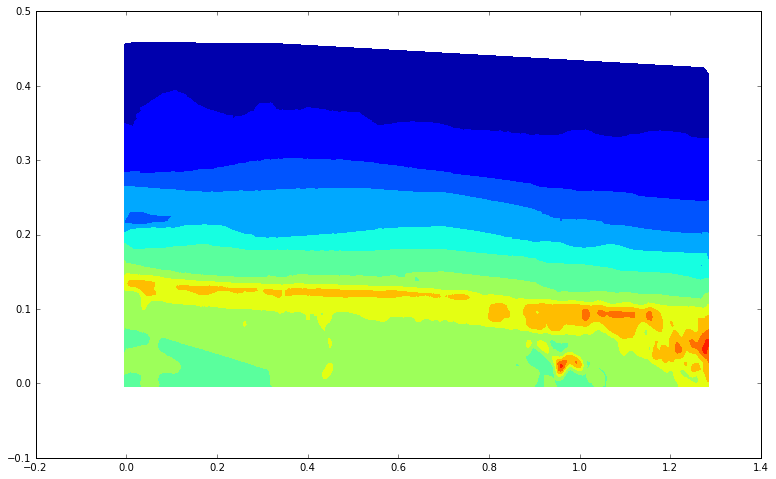

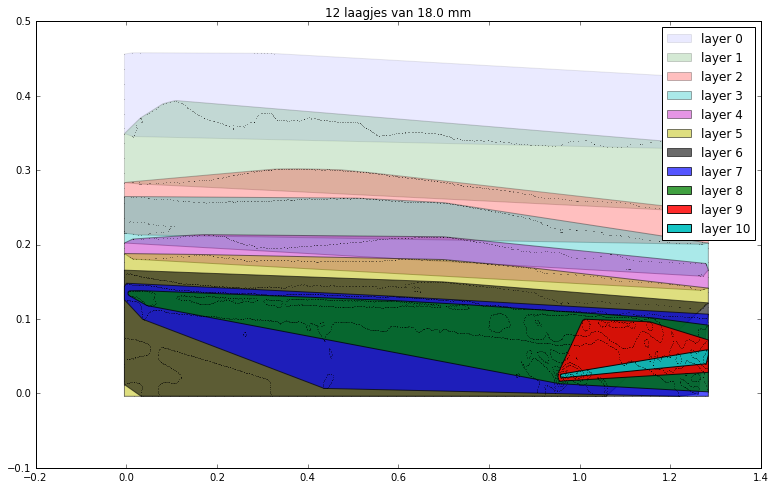

In [51]:
t_wood = .018
V = np.arange(0, 0.2+t_wood, t_wood)
# print 'layer boundaries:', V
plt.figure(figsize=(13, 8))
contours = plt.tricontourf(tri, xyzz[:,2], V)


plt.subplots(figsize=(13, 8))

for i, segment in enumerate(contours.allsegs[:-1]):
    contour = segment[0]
    hull = scipy.spatial.ConvexHull(contour)
    hull_points = hull.points[hull.vertices]
    plt.plot(contour[:,0], contour[:,1], 'k.', alpha=0.2, markersize=1)
    plt.fill(hull_points[:,0], hull_points[:,1], alpha=(i+1.) / len(contours.allsegs), label='layer '+str(i))
#     plt.plot(hull_points[:,0], hull_points[:,1], label='layer '+str(i))

plt.legend()
plt.title(str(len(V)-1) + ' laagjes van ' + str(t_wood*1000) + ' mm');

In [108]:
tri = matplotlib.tri.Triangulation(xyzz[:,0], xyzz[:,1])

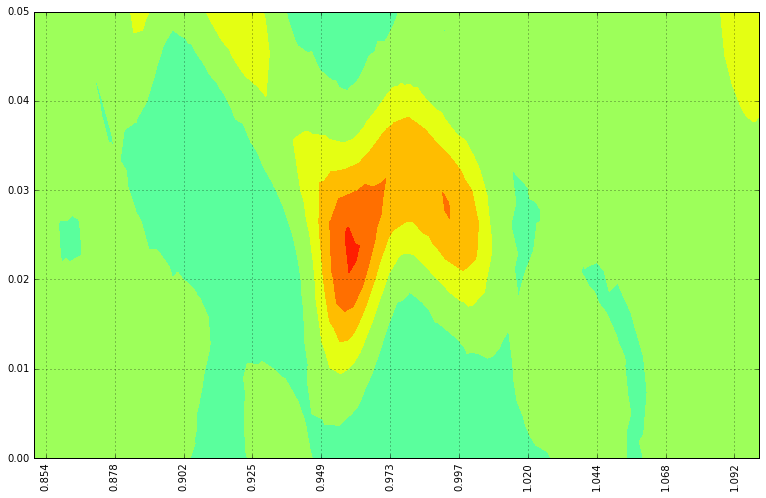

In [109]:
plt.figure(figsize=(13, 8))
contours = plt.tricontourf(tri, xyzz[:,2], V)
plt.xticks(np.linspace(0, 1.4, 60), rotation=90)
plt.xlim(.85, 1.1)
plt.ylim(0, .05)
plt.grid()

In [117]:
ert = xyzz[:, 2][  (xyzz[:, 0] > 1.02) & (xyzz[:, 0] < 1.08) & (xyzz[:, 1] > .02) & (xyzz[:, 1] < .03)]
ertt = xyzz[  (xyzz[:, 0] > 1.05) & (xyzz[:, 0] < 1.2) & (xyzz[:, 1] < .05)]

ertm = np.mean(ert)
print ertm

tre = xyzz[      (xyzz[:, 0] > .925) & (xyzz[:, 0] < 1.02) & 
                 (xyzz[:, 1] > .01) & (xyzz[:, 1] < .045) & 
                 (xyzz[:, 2] > np.mean(ert))]

tre2 = tre.copy()
tre2[:, 2] = ertm + (tre2[:, 2] - ertm) * .2

plt.figure(figsize=(13, 8))
triii = matplotlib.tri.Triangulation(tre[:,0], tre[:,1])
# contours = plt.tricontourf(triii, tre[:,2], V)

plt.figure(figsize=(13, 8))
triii = matplotlib.tri.Triangulation(tre2[:,0], tre2[:,1])
# contours = plt.tricontourf(triii, tre2[:,2], V)

0.109353860489


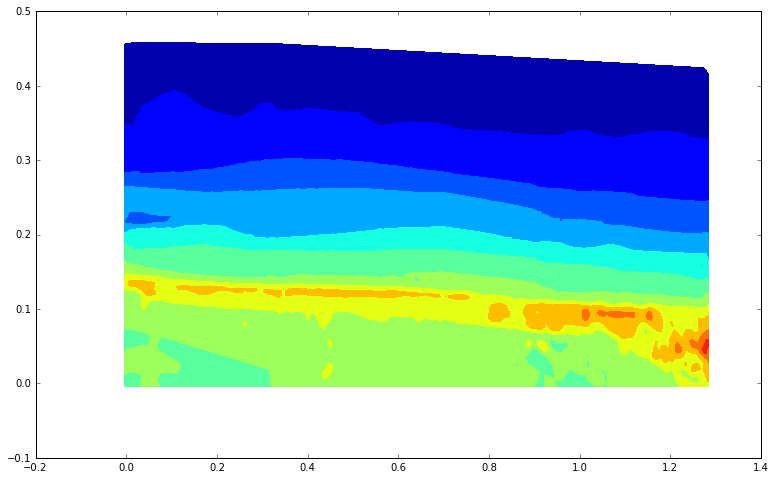

In [118]:
xyzzz = xyzz.copy()
xyzzz[      (xyzz[:, 0] > .925) & (xyzz[:, 0] < 1.02) & 
            (xyzz[:, 1] > .01) & (xyzz[:, 1] < .045) & 
            (xyzz[:, 2] > np.mean(ert))]          =       tre2

plt.figure(figsize=(13, 8))
contours = plt.tricontourf(tri, xyzzz[:,2], V)

In [119]:
# see https://github.com/dranjan/python-plyfile
# compute vertex array (bit of hack with the tulpes)
vertex = np.array([
        tuple(row) 
        for row
        in xyzzz.tolist()
    ], dtype=[
        ('x', 'f4'),
        ('y', 'f4'),
        ('z', 'f4')
    ])

# create a list of tuples followed by red,green,blue
facelist = []
for triangle in tri.triangles:
    z_triangle = xyzzz[triangle[0], 2]
    r, g, b, a = matplotlib.cm.gist_earth(N(z_triangle), bytes=True)
    facelist.append((triangle, r, g, b))
    
face = np.array(facelist,
                dtype=[
        ('vertex_indices', 'i4', (3,)),
        ('red', 'u1'), ('green', 'u1'),
        ('blue', 'u1')
    ])

In [121]:
ply = plyfile.PlyData([
        plyfile.PlyElement.describe(
                vertex, 'vertex',
                comments=['tetrahedron vertices']
        ),
        plyfile.PlyElement.describe(face, 'face')
    ],
    text=True, 
    byte_order='=',
    comments=['single tetrahedron with colored faces']
)
ply.write('filename2.ply')

In [48]:
# fig = plt.figure(figsize=(13, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z)

# surf1 = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, color='g',
#                        linewidth=0, antialiased=False, alpha=0.5)

# plt.show()

Original z values:
[-0.34127933 -0.30729404  0.21155127  0.82107652  0.17163933 -0.44447561
 -0.62316986 -0.07631452 -0.2452825   0.08006371 -0.16038592 -1.15094797
  0.97879369 -0.59069121  0.28481385 -0.61505364 -1.28958296 -0.40040525
 -0.62065409  0.10887611  0.11082111 -0.57756184 -0.08303365  0.1736536
 -0.11741524 -0.25279036 -0.87523777 -0.62589892  0.14774674  1.02822874
  1.40065013  0.0570847  -1.24442082  1.29216089  0.04075983  0.35829967]
Smoothed z values:
[-0.4760952  -0.32638375  0.33082556  0.81805681  0.04136433 -0.04617472
 -0.6941891  -0.17280308 -0.21626414 -0.25286811 -0.19661876 -1.04547018
  1.19599927 -0.55479106  0.3257578  -0.35879233 -0.9914419  -0.74646378
 -0.60559207 -0.11546096 -0.10684431 -0.35038102  0.05290993  0.10818459
 -0.07302746 -0.33240211 -0.82955756 -0.32360917  0.11565045  0.98144511
  1.22421926 -0.08092414 -0.97381114  1.16754806  0.01186976  0.11594726]


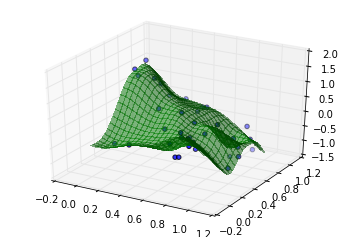

In [49]:
# Generate some random (x, y, z) values.
npoints = 36
np.random.seed(12345)
x, y = np.random.rand(2, npoints)
z = np.cos(3*x)*np.sin(2*y) + 0.4*np.random.randn(npoints)


# "Interpolator" with smoothing
f = Rbf(x, y, z, smooth=0.05)

print("Original z values:")
print(z)
print("Smoothed z values:")
print(f(x, y))

u = np.linspace(0, 1, 25)
xx, yy = np.meshgrid(u, u)
zz = f(xx, yy)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

surf1 = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, color='g',
                       linewidth=0, antialiased=False, alpha=0.5)

plt.show()

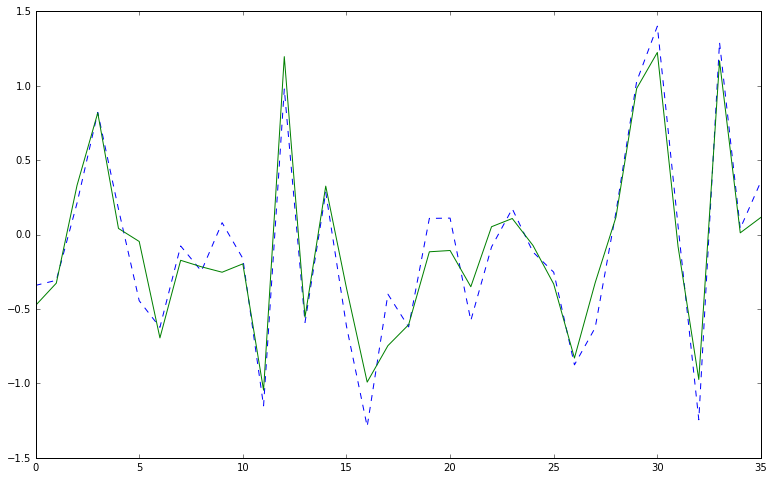

In [50]:
plt.figure(figsize=(13,8))
plt.plot(z, '--')
plt.plot(f(x, y))